In [17]:
import numpy as np
import spectrumtools as spt
import matplotlib.pyplot as plt

# Notes

Select a file

In [18]:
nucleus="154Sm"
xnucleus=nucleus[3:]+nucleus[0:3]  # fiddle name and A !
path=spt.findstore(xnucleus)

angle=0.4
lump=1
targetfilename="data_154Sm_all_5keV.dat"
# at 5 keV / channel
ROIlo,ROIhi=(40*5,360*5)  # 1600 chans: 200 - 1800
        
ROIlo=ROIlo+50
ROIhi=ROIhi+50
        
# *** Read in data
try:
    print("data input from ",path+targetfilename)
    e,cs0=np.loadtxt(path+targetfilename,unpack=True,usecols=(0,1))
    de=e[2]-e[1]
    # energy in MeV: find kev/ch as int
    intde=int(de*1000.0+0.1)
    G=cs0
    X=e
except:
    raise(ValueError,("File not found"))
 

data input from  /Users/rogerfearick/Desktop/research/linax/datastore/Sm154/data_154Sm_all_5keV.dat


Create objects

In [66]:
sig = 25.0/2.35/1000.0
sigsm=3.5*sig
sigsmn=0.39*2.35*sig
sigx=sigsm*2.5
print("sig=%6.4f  sigsm=%7.4f sigsmn=%7.4f MeV"%(sig,sigsm,sigsmn))

S=spt.RatioSpectrum( X, G, targetfilename, ROIlo, ROIhi )
globalenergy = S.energy

S.makeRatioSpectra( sigsmn*1000, sigsm*1000 )

bins=spt.ACBinner(S)
print("Computed bin limits:\n",bins.get_bins())

sig=0.0106  sigsm= 0.0372 sigsmn= 0.0097 MeV
Computed bin limits:
 [(0, 400), (80, 480), (160, 560), (240, 640), (320, 720), (400, 800), (480, 880), (560, 960), (640, 1040), (720, 1120), (800, 1200), (880, 1280), (960, 1360), (1040, 1440), (1120, 1520), (1200, 1600)]


Select a dataset

Bin limits:    7.053 ..    9.047 MeV


Text(0.8,0.8,'7')

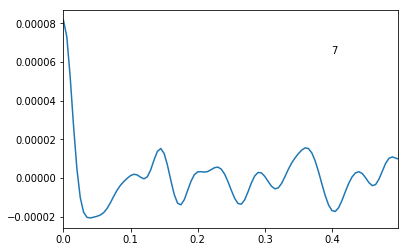

In [77]:
binlist=bins.get_bins()
index=7
l,h=binlist[index]
print("Bin limits: %8.3f .. %8.3f MeV"%bins.get_bin_limits(index))
bin=spt.Bin(bins.data,l,h)
energy=bin.Eoffset
data=bin.acnar
plt.plot(energy, data)
plt.xlim(0.0,energy[-1]/4)
plt.text(0.8,0.8,"%d"%index,transform=plt.gca().transAxes)

Now set up for fits

In [78]:
import lmfit

def fitforlm( params, e, data, unc=None ):
    """
    fit function for least sq fit using lmfit
    """
    global alpha
    p=params.valuesdict()
    D=p['D']
    sign=p['sign']
    sigw=p['sigw']
    sigx=p['sigx']
    ys=sigw/sign
    ysp=1.+ys*ys
    sig=sign
    model=(1.0/(2.0*np.sqrt(np.pi)*sig))*(alpha*D)*np.exp(-e*e/(4.*sig*sig))
    model+=(1.0/(2.0*np.sqrt(np.pi)*sig*ys))*(alpha*D)*np.exp(-e*e/(4.*sig*sig*ys*ys))
    model-=(1.0/(2.0*np.sqrt(np.pi)*sig))*(alpha*D)*np.sqrt(8./ysp)*np.exp(-e*e/(2.*sig*sig*ysp))
    model*=np.exp(-e*e/(2.0*sigx**2))
    if unc is None:
        unc=np.ones(len(data))
    return (model-data)/unc

def model(params, e):
    p=params.valuesdict()
    D=p['D']
    sign=p['sign']
    sigw=p['sigw']
    sigx=p['sigx']
    ys=sigw/sign
    ysp=1.+ys*ys
    sig=sign
    model=(1.0/(2.0*np.sqrt(np.pi)*sig))*(alpha*D)*np.exp(-e*e/(4.*sig*sig))
    model+=(1.0/(2.0*np.sqrt(np.pi)*sig*ys))*(alpha*D)*np.exp(-e*e/(4.*sig*sig*ys*ys))
    model-=(1.0/(2.0*np.sqrt(np.pi)*sig))*(alpha*D)*np.sqrt(8./ysp)*np.exp(-e*e/(2.*sig*sig*ysp))
    #model*=np.exp(-e*e/(2.0*sigx**2))
    return model

alpha=2.273
initialD=data[0]*(2.0*np.sqrt(np.pi)*sig)/alpha
ndata=len(data)
params=lmfit.Parameters()
params.add('D',value=initialD, min=0.0)
params.add('sign',value=sig,min=0.0)
params.add('sigw',value=sigsm,min=0.0,vary=False)
params.add('sigx',value=sigx,vary=False)
noise=bin.get_noise_correction(sigsmn, sigsm)
uncert=np.linspace(data[0]/10,data[0]/5,ndata)
ACfx=(data-noise)*np.exp(-energy**2/(2.0*sigx**2))
#initial=1.0
#popt,pcov=curve_fit(fitf2, Xac, ACf, p0=[initial,sig])
#sig=popt[1]
#popt[0]*=initialD
minner=lmfit.Minimizer(fitforlm, params, fcn_args=(energy,ACfx),
                       fcn_kws={'unc':uncert})
result=minner.minimize()
lmfit.printfuncs.report_fit(result.params)

p=result.params.valuesdict()
rho=1.0/p['D']
elo,ehi=bins.get_bin_limits(index)
en=(elo+ehi)/2
print(en,rho,1.0/initialD,p['sigw'],p['sign'],p['sigx'])

[[Variables]]
    D:      2.3588e-05 +/- 4.02e-06 (17.04%) (init= 1.352454e-06)
    sign:   0.02914177 +/- 0.000589 (2.02%) (init= 0.0106383)
    sigw:   0.03723404 (fixed)
    sigx:   0.09308511 (fixed)
[[Correlations]] (unreported correlations are <  0.100)
    C(D, sign)                   =  0.995 
8.05 42393.70642685556 739396.6829189684 0.03723404255319149 0.029141773506490276 0.09308510638297872


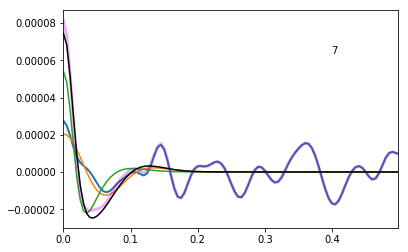

In [79]:
m=model(result.params, energy)
plt.plot(energy, data-noise,lw=2)
plt.xlim(0.0,energy[-1]/4)
plt.text(0.8,0.8,"%d"%index,transform=plt.gca().transAxes)
plt.plot(energy,m)
plt.plot(energy,noise)
plt.plot(energy,data,'m-',lw=3.0,alpha=0.3)
plt.plot(energy,m+noise,'k-')

Now Bayes

In [61]:
# def function to be used in MC uncertainty analysis (the log likelihood)
def loglike(param, f, data, unc=None):
    #noise=param['noise']
    return -0.5*(np.sum(fitforlm(param,f,data,unc)**2)+np.log(2.0*np.pi*np.sum(unc*unc)))

# MC for parameters: use the log likelihood function.
mcmin = lmfit.Minimizer(loglike, minner.params, fcn_args=(energy, data*np.exp(-energy**2/(2.0*sigx**2))),fcn_kws={'unc':uncert})
res = mcmin.emcee(burn=300, steps=1000, thin=5, params=minner.params, is_weighted=True)
print("done") # takes a while, needs some feedback.

done


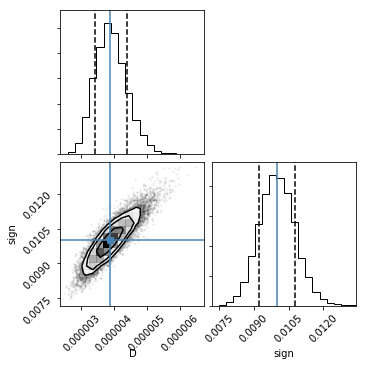

In [62]:
import corner
figure=corner.corner(res.flatchain, bins=20, quantiles=(0.16,0.84), 
                     labels=res.var_names, truths=list(res.params.valuesdict().values()))

Group

In [63]:
rholist=[]
for i,(l,h) in enumerate(binlist):
    bin=spt.Bin(bins.data,l,h)
    energy=bin.Eoffset
    data=bin.acnar
    alpha=2.4
    initialD=data[0]*(2.0*np.sqrt(np.pi)*sig)/alpha
    ndata=len(data)
    params=lmfit.Parameters()
    params.add('D',value=initialD, min=0.0)
    params.add('sign',value=sig,min=0.0)
    params.add('sigw',value=sigsm,min=0.0,vary=False)
    params.add('sigx',value=sigx,vary=False)
    noise=bin.get_noise_correction(sigsmn, sigsm)
    uncert=np.linspace(data[0]/10,data[0]/5,ndata)
    ACfx=(data-noise)*np.exp(-energy**2/(2.0*sigx**2))
    #initial=1.0
    #popt,pcov=curve_fit(fitf2, Xac, ACf, p0=[initial,sig])
    #sig=popt[1]
    #popt[0]*=initialD
    minner=lmfit.Minimizer(fitforlm, params, fcn_args=(energy,ACfx),
                           fcn_kws={'unc':uncert})
    result=minner.minimize()
    #lmfit.printfuncs.report_fit(result.params)
    p=result.params.valuesdict()
    rho=1.0/p['D']
    elo,ehi=bins.get_bin_limits(i)
    en=(elo+ehi)/2
    rholist.append((en,rho))

In [64]:
rholist=np.array( rholist )
print(np.shape(rholist))

(16, 2)


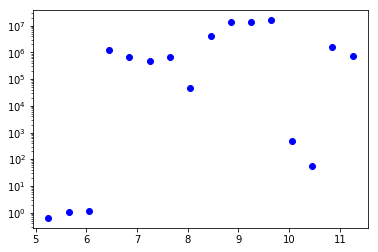

In [65]:
e=rholist.T[0]
rho=rholist.T[1]
plt.semilogy(e,rho,'bo')